In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM

import numpy as np

In [2]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction

print(dataset.head(30))

#dewp dew point
#pm2.5 pollution measure
#cbwd wind direction
#Iws cumulated wind speed
#Is cumulated hours of snow
#Ir cumulated hours of rain

    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
No                                                                       
1   2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2   2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
3   2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
4   2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
5   2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
6   2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
7   2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
8   2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
9   2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0
11  2010      1    1    10    NaN   -19  -7.0  1017.0   NW  31.30   0   0
12  2010      1    1    11    NaN   -1

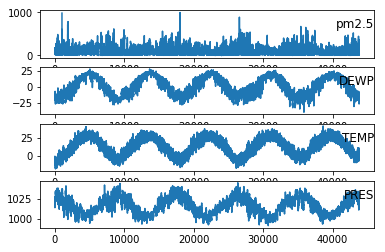

<Figure size 28800x28800 with 0 Axes>

In [3]:
# specify columns to plot
groups = [  4,5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.figure(figsize=(400,400))
plt.show()

In [4]:
# Prepare dataset: supervised learning (pollution at previous timestep and weather conditions)
# 

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])

In [6]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
scaled[:1]

array([[0.        , 0.        , 0.        , 0.        ,        nan,
        0.2794118 , 0.13114753, 0.545454  , 0.33333334, 0.00229001,
        0.        , 0.        ]], dtype=float32)

In [9]:
# specify the number of lag hours
n_hours = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(40969, 60)


In [10]:
# split into train and test sets
n_features = 8
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 4, 8) (8760,) (32209, 4, 8) (32209,)


In [82]:
train[1]

array([0.        , 0.        , 0.03333334, 0.04347826, 0.14889336,
       0.36764708, 0.24590163, 0.5272732 , 0.6666667 , 0.00381099,
       0.        , 0.        , 0.        , 0.        , 0.03333334,
       0.08695652, 0.15995975, 0.4264706 , 0.22950819, 0.545454  ,
       0.6666667 , 0.00533197, 0.        , 0.        , 0.        ,
       0.        , 0.03333334, 0.13043478, 0.18209255, 0.48529413,
       0.22950819, 0.5636368 , 0.6666667 , 0.00839101, 0.03703704,
       0.        , 0.        , 0.        , 0.03333334, 0.17391305,
       0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
       0.00991199, 0.07407407, 0.        ], dtype=float32)

In [84]:
train_X.shape

(8760, 3, 8)

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

W0526 10:29:30.124251 4451950016 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 32209 samples


W0526 10:29:52.186000 4451950016 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
8760/8760 - 3s - loss: 0.0576 - val_loss: 0.1077
Epoch 2/30
8760/8760 - 2s - loss: 0.0521 - val_loss: 0.0943
Epoch 3/30
8760/8760 - 2s - loss: 0.0511 - val_loss: 0.0940
Epoch 4/30
8760/8760 - 2s - loss: 0.0495 - val_loss: 0.0927
Epoch 5/30
8760/8760 - 2s - loss: 0.0469 - val_loss: 0.0894
Epoch 6/30
8760/8760 - 2s - loss: 0.0426 - val_loss: 0.0790
Epoch 7/30
8760/8760 - 2s - loss: 0.0381 - val_loss: 0.0703
Epoch 8/30
8760/8760 - 4s - loss: 0.0357 - val_loss: 0.0579
Epoch 9/30
8760/8760 - 3s - loss: 0.0305 - val_loss: 0.0538
Epoch 10/30
8760/8760 - 3s - loss: 0.0277 - val_loss: 0.0525
Epoch 11/30
8760/8760 - 3s - loss: 0.0260 - val_loss: 0.0507
Epoch 12/30
8760/8760 - 3s - loss: 0.0255 - val_loss: 0.0541
Epoch 13/30
8760/8760 - 2s - loss: 0.0251 - val_loss: 0.0555
Epoch 14/30
8760/8760 - 2s - loss: 0.0244 - val_loss: 0.0474
Epoch 15/30
8760/8760 - 2s - loss: 0.0238 - val_loss: 0.0384
Epoch 16/30
8760/8760 - 2s - loss: 0.0234 - val_loss: 0.0302
Epoch 17/30
8760/8760 - 2s - loss

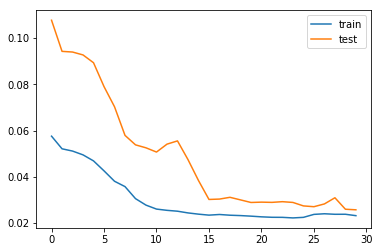

In [14]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# design network
modeld = Sequential()
modeld.add(Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
modeld.add(Dense(500,activation='relu'))
modeld.add(Dense(1))
modeld.compile(loss='mae', optimizer='adam')
modeld.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               16500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 17,001
Trainable params: 17,001
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit network
history = modeld.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 32209 samples
Epoch 1/50
8760/8760 - 1s - loss: 0.0847 - val_loss: 0.0533
Epoch 2/50
8760/8760 - 1s - loss: 0.0460 - val_loss: 0.1003
Epoch 3/50
8760/8760 - 1s - loss: 0.0536 - val_loss: 0.0735
Epoch 4/50
8760/8760 - 1s - loss: 0.0506 - val_loss: 0.1055
Epoch 5/50
8760/8760 - 1s - loss: 0.0389 - val_loss: 0.0641
Epoch 6/50
8760/8760 - 1s - loss: 0.0344 - val_loss: 0.0584
Epoch 7/50
8760/8760 - 1s - loss: 0.0336 - val_loss: 0.0412
Epoch 8/50
8760/8760 - 1s - loss: 0.0373 - val_loss: 0.0716
Epoch 9/50
8760/8760 - 1s - loss: 0.0315 - val_loss: 0.0308
Epoch 10/50
8760/8760 - 1s - loss: 0.0267 - val_loss: 0.0639
Epoch 11/50
8760/8760 - 1s - loss: 0.0322 - val_loss: 0.0284
Epoch 12/50
8760/8760 - 1s - loss: 0.0319 - val_loss: 0.0407
Epoch 13/50
8760/8760 - 1s - loss: 0.0289 - val_loss: 0.0319
Epoch 14/50
8760/8760 - 1s - loss: 0.0297 - val_loss: 0.0416
Epoch 15/50
8760/8760 - 2s - loss: 0.0319 - val_loss: 0.0323
Epoch 16/50
8760/8760 - 1s - loss: 0.0290 - v

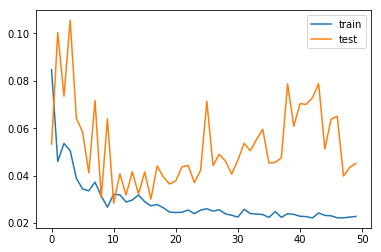

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
yhat = model.predict(test_X)
yhatd = modeld.predict(test_X)

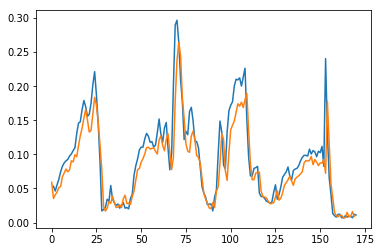

In [19]:
plt.plot(1+np.arange(len(test_y[:170])),test_y[:170])
plt.plot(np.arange(len(test_y[:170])),yhat[:170,0])
#plt.plot(np.arange(len(test_y[:150])),yhatd[:150,0])

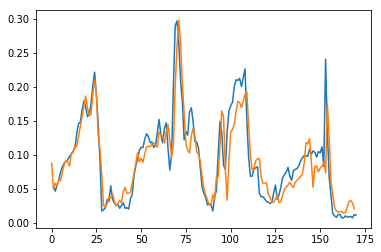

In [20]:
plt.plot(1+np.arange(len(test_y[:170])),test_y[:170])
#plt.plot(np.arange(len(test_y[:150])),yhat[:150,0])
plt.plot(np.arange(len(test_y[:170])),yhatd[:170,0])

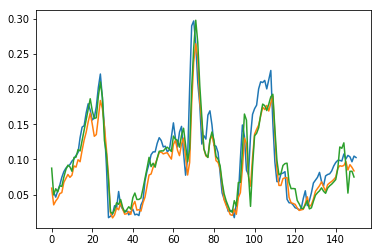

In [21]:
plt.plot(1+np.arange(len(test_y[:150])),test_y[:150])
plt.plot(np.arange(len(test_y[:150])),yhat[:150,0])
plt.plot(np.arange(len(test_y[:150])),yhatd[:150,0])